# In Depth: Linear Regression



In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

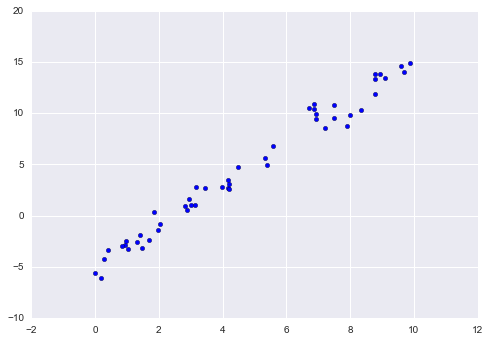

In [ ]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

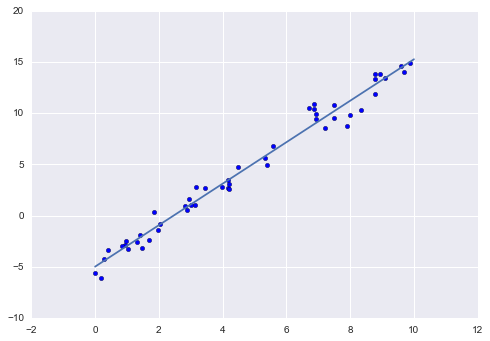

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [ ]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.02720881036
Model intercept: -4.99857708555


We see that the results are very close to the inputs, as we might hope.

The ``LinearRegression`` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [ ]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single ``LinearRegression`` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.
We have seen one version of this before, in the ``PolynomialRegression`` pipeline used in [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) and [Feature Engineering](05.04-Feature-Engineering.ipynb).
The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

As we saw in [Feature Engineering](05.04-Feature-Engineering.ipynb), the cleanest way to accomplish this is to use a pipeline.
Let's make a 7th-degree polynomial model in this way:

In [ ]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

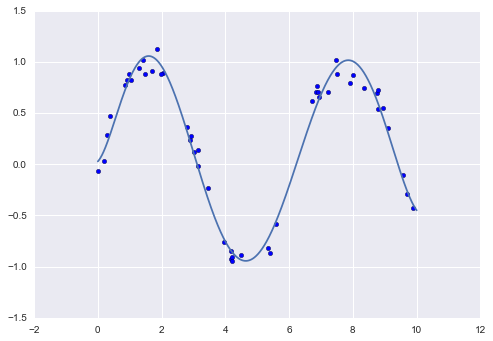

In [ ]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

### Gaussian basis functions

Of course, other basis functions are possible.
For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases.
The result might look something like the following figure:

![](figures/05.06-gaussian-basis.png)
[figure source in Appendix](#Gaussian-Basis)

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data.
These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, as shown here and illustrated in the following figure (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created):

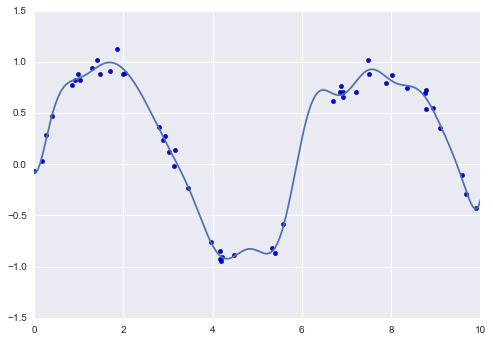

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for a discussion of this).
For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

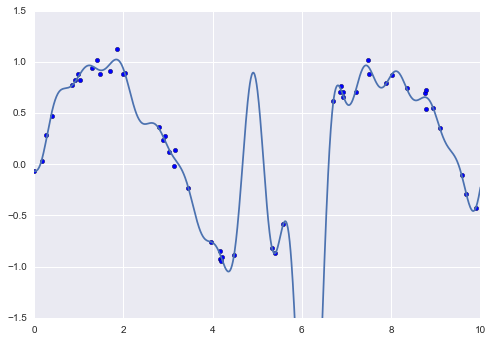

In [ ]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.
We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

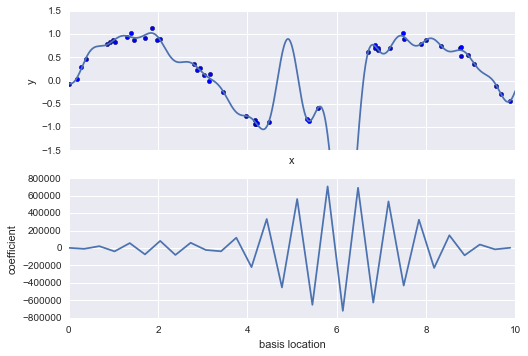

In [ ]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function at each location.
This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out.
We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters.
Such a penalty is known as *regularization*, and comes in several forms.

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator:

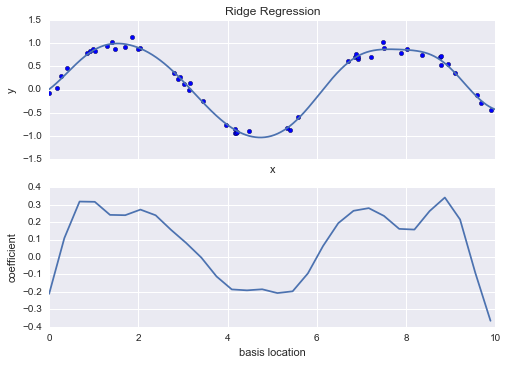

In [ ]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

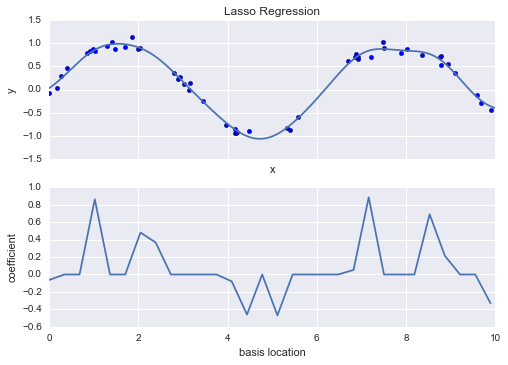

In [ ]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions.
As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for a discussion of this).

## Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.
We have seen this data already in [Working With Time Series](03.11-Working-with-Time-Series.ipynb).

In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.
Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.
We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning.
As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

In [ ]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

In [ ]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [ ]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [ ]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

(8, 17)

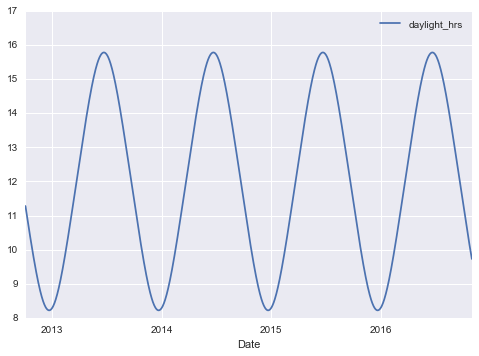

In [ ]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [ ]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [ ]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [ ]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set ``fit_intercept = False``, because the daily flags essentially operate as their own day-specific intercepts:

In [ ]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

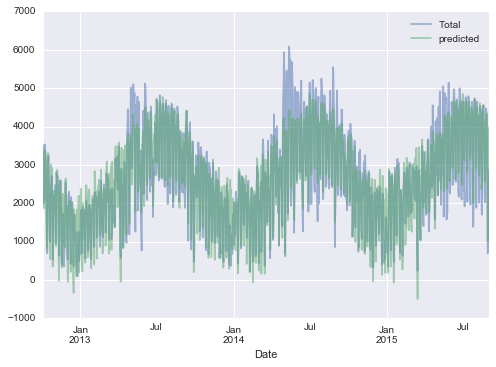

In [ ]:
daily[['Total', 'predicted']].plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [ ]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty.
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [ ]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [ ]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays.
We see that for each additional hour of daylight, 129 ± 9 more people choose to ride; a temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle; a dry day means an average of 548 ± 33 more riders, and each inch of precipitation means 665 ± 62 more people leave their bike at home.
Once all these effects are accounted for, we see a modest increase of 27 ± 18 new daily riders each year.

Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

# In-Depth: Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

As part of our disussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

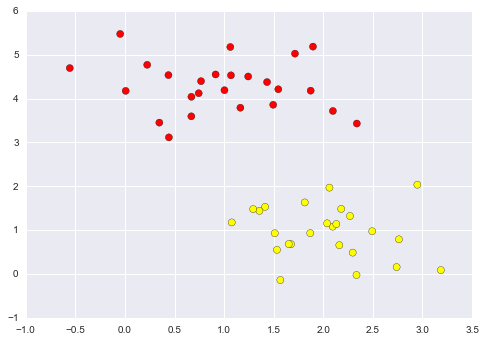

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

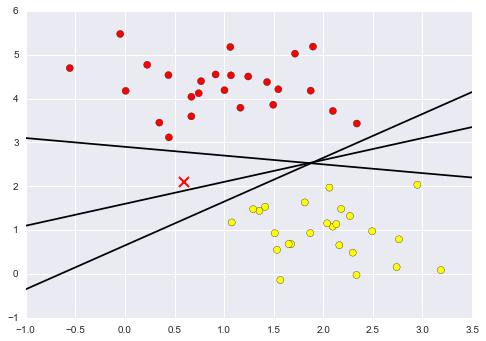

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

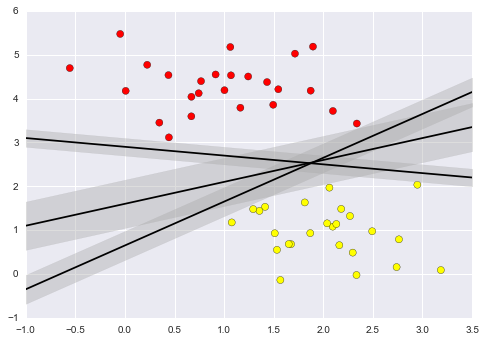

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

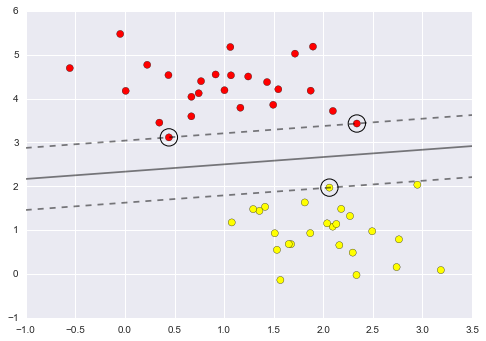

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [ ]:
model.support_vectors_

array([[ 0.44359863,  3.11530945],
       [ 2.33812285,  3.43116792],
       [ 2.06156753,  1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

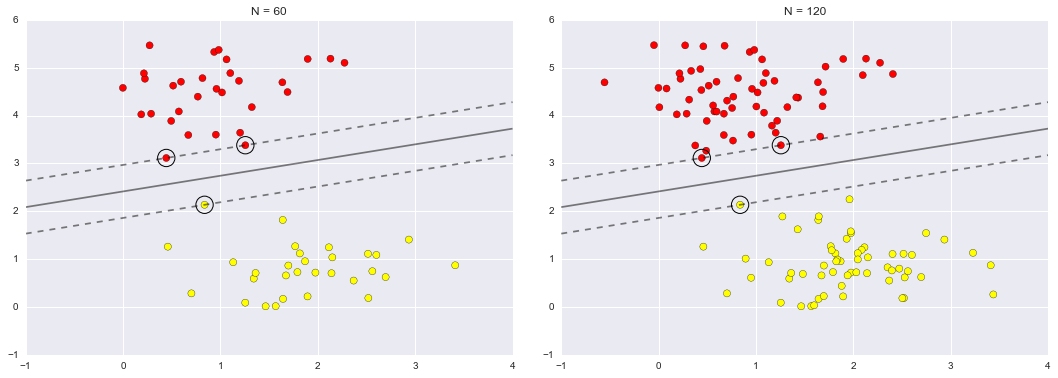

In [ ]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

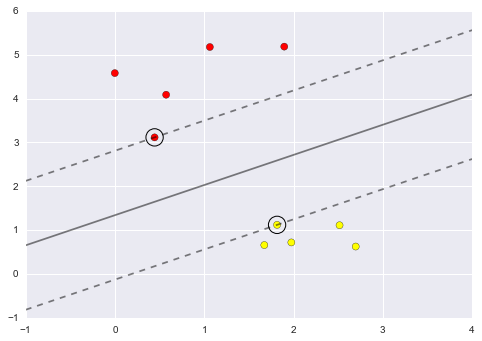

In [ ]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).
There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

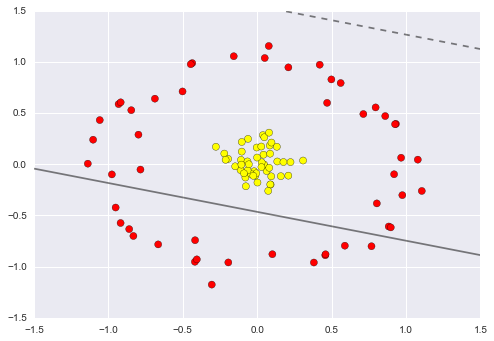

In [ ]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [ ]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

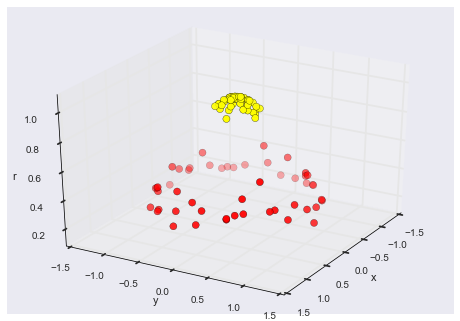

In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [ ]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

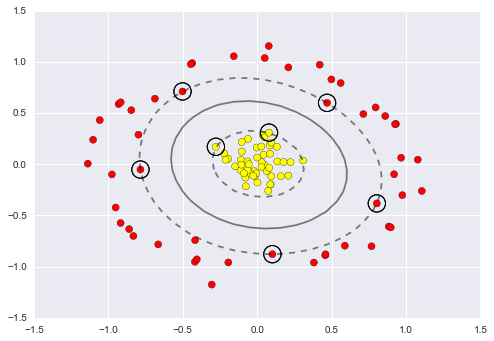

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

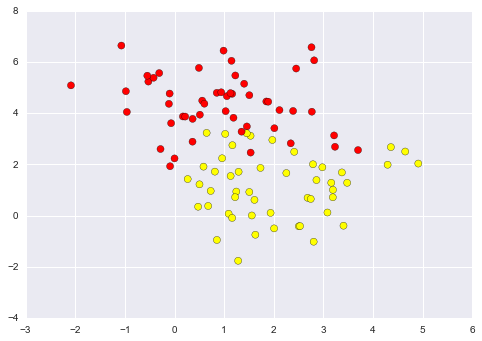

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

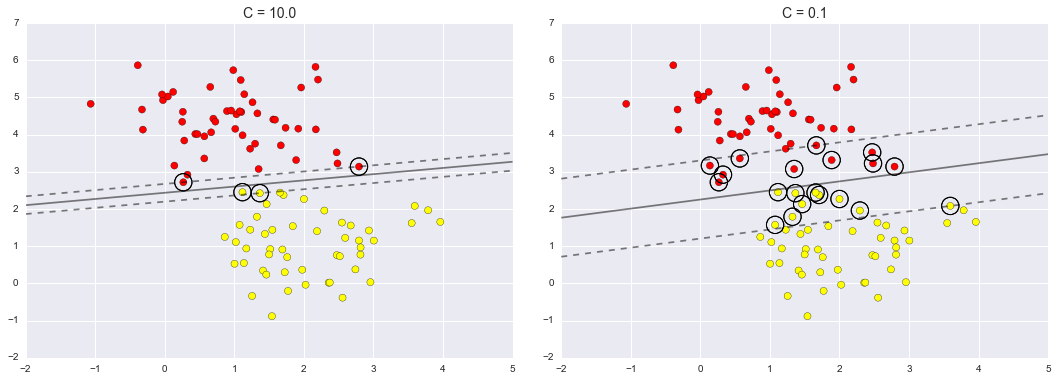

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

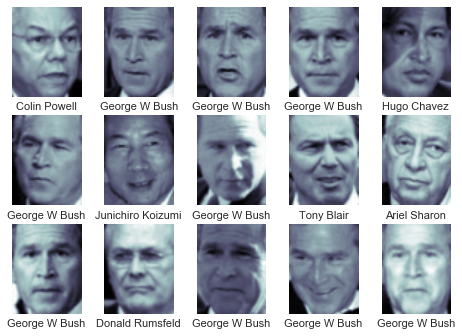

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [ ]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [ ]:
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 47.8 s, sys: 4.08 s, total: 51.8 s
Wall time: 26 s
{'svc__gamma': 0.001, 'svc__C': 10}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

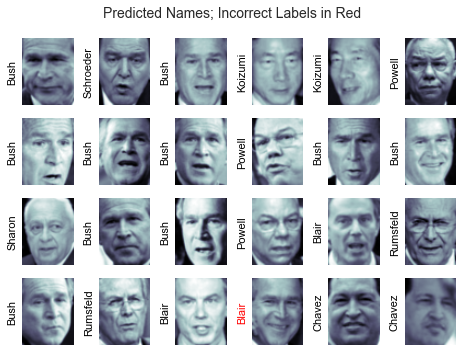

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.81      0.87      0.84        68
  Donald Rumsfeld       0.75      0.87      0.81        31
    George W Bush       0.93      0.83      0.88       126
Gerhard Schroeder       0.86      0.78      0.82        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.80      1.00      0.89        12
       Tony Blair       0.83      0.93      0.88        42

      avg / total       0.85      0.85      0.85       337



We might also display the confusion matrix between these classes:

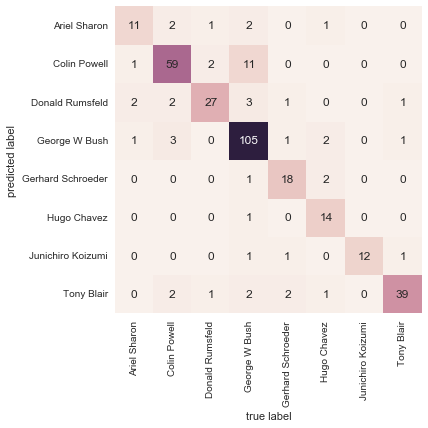

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

# In-Depth: Decision Trees and Random Forests


Here we'll take a look at motivating another powerful algorithm—a non-parametric algorithm called *random forests*.
Random forests are an example of an *ensemble* method, meaning that it relies on aggregating the results of an ensemble of simpler estimators.
The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting!
We will see examples of this in the following sections.
We begin with the standard imports:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivating Random Forests: Decision Trees

Random forests are an example of an *ensemble learner* built on decision trees.
For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.
For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Example)

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

### Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

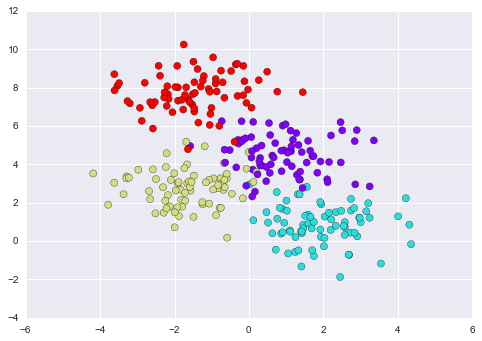

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
This figure presents a visualization of the first four levels of a decision tree classifier for this data:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a quick utility function to help us visualize the output of the classifier:

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like:

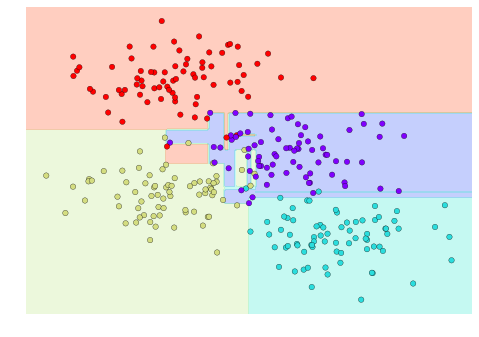

In [ ]:
visualize_classifier(DecisionTreeClassifier(), X, y)

If you're running this notebook live, you can use the helpers script included in [The Online Appendix](06.00-Figure-Code.ipynb#Helper-Code) to bring up an interactive visualization of the decision tree building process:

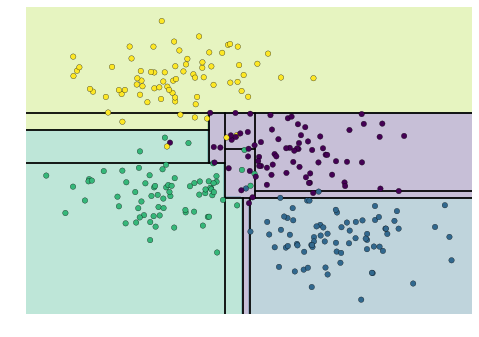

In [ ]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

### Decision trees and over-fitting

Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.
Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

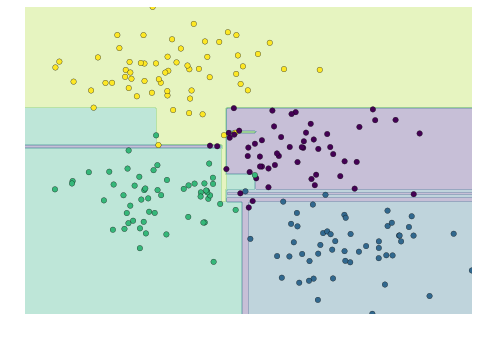

In [ ]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

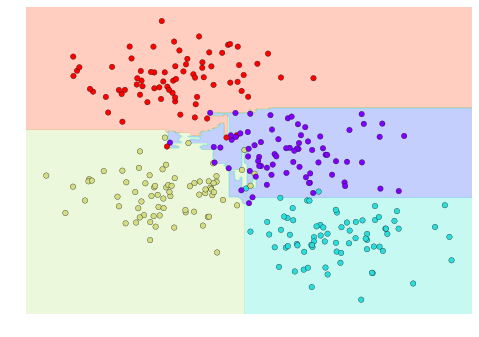

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

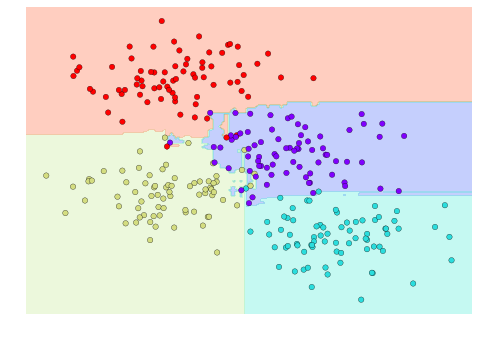

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

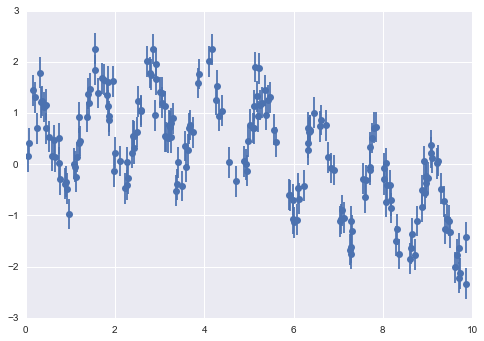

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

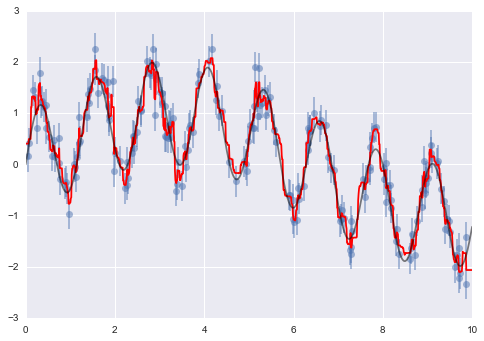

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classifying Digits

Earlier we took a quick look at the hand-written digits data (see [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb)).
Let's use that again here to see how the random forest classifier can be used in this context.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['target', 'data', 'target_names', 'DESCR', 'images'])

To remind us what we're looking at, we'll visualize the first few data points:

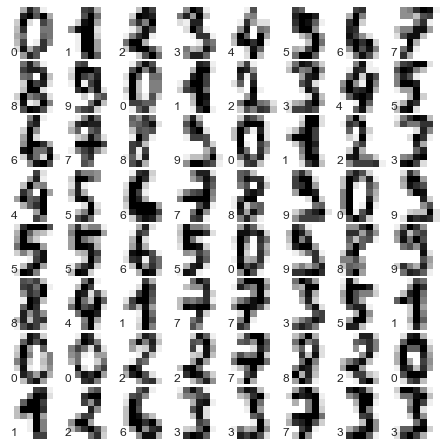

In [ ]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a random forest as follows:

In [ ]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        38
          1       1.00      0.98      0.99        44
          2       0.95      1.00      0.98        42
          3       0.98      0.96      0.97        46
          4       0.97      1.00      0.99        37
          5       0.98      0.96      0.97        49
          6       1.00      1.00      1.00        52
          7       1.00      0.96      0.98        50
          8       0.94      0.98      0.96        46
          9       0.96      0.98      0.97        46

avg / total       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

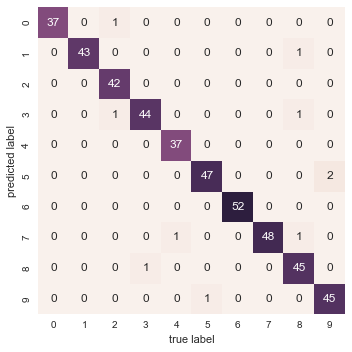

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a very accurate classification of the digits data.

## Summary of Random Forests

This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the ``predict_proba()`` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

# K-nearest neighbor Classification

### Import packages and data set

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
!git clone https://github.com/TheBrainCodeGames/2021_seminars.git

Cloning into '2021_seminars'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [ ]:
df = pd.read_csv("/content/2021_seminars/AI/Datasets/Classified Data",index_col=0)
df.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   WTT           1000 non-null   float64
 1   PTI           1000 non-null   float64
 2   EQW           1000 non-null   float64
 3   SBI           1000 non-null   float64
 4   LQE           1000 non-null   float64
 5   QWG           1000 non-null   float64
 6   FDJ           1000 non-null   float64
 7   PJF           1000 non-null   float64
 8   HQE           1000 non-null   float64
 9   NXJ           1000 non-null   float64
 10  TARGET CLASS  1000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 93.8 KB


In [ ]:
df.describe()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.949682,1.114303,0.834127,0.682099,1.032336,0.943534,0.963422,1.071960,1.158251,1.362725,0.50000
std,0.289635,0.257085,0.291554,0.229645,0.243413,0.256121,0.255118,0.288982,0.293738,0.204225,0.50025
min,0.174412,0.441398,0.170924,0.045027,0.315307,0.262389,0.295228,0.299476,0.365157,0.639693,0.00000
25%,0.742358,0.942071,0.615451,0.515010,0.870855,0.761064,0.784407,0.866306,0.934340,1.222623,0.00000
50%,0.940475,1.118486,0.813264,0.676835,1.035824,0.941502,0.945333,1.065500,1.165556,1.375368,0.50000
75%,1.163295,1.307904,1.028340,0.834317,1.198270,1.123060,1.134852,1.283156,1.383173,1.504832,1.00000
max,1.721779,1.833757,1.722725,1.634884,1.650050,1.666902,1.713342,1.785420,1.885690,1.893950,1.00000


### Check the spread of the features

In [ ]:
l=list(df.columns)
l[0:len(l)-2]

['WTT', 'PTI', 'EQW', 'SBI', 'LQE', 'QWG', 'FDJ', 'PJF', 'HQE']

**Run a 'for' loop to draw boxlots of all the features for '0' and '1' TARGET CLASS**

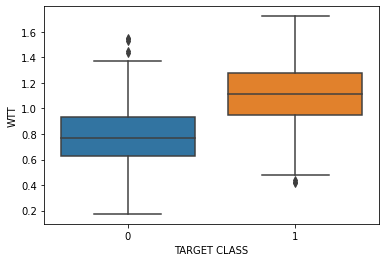

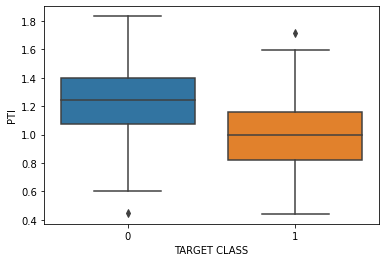

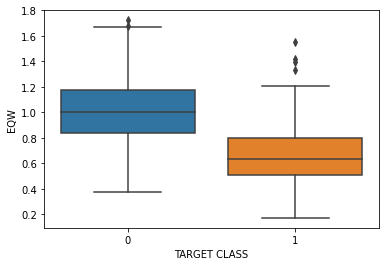

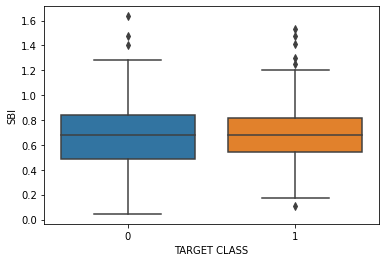

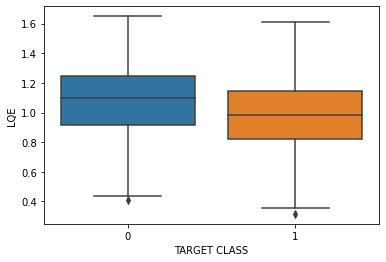

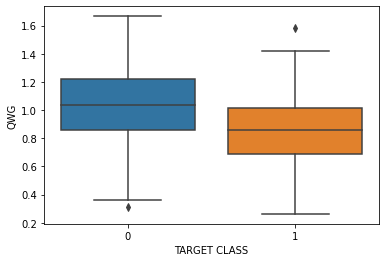

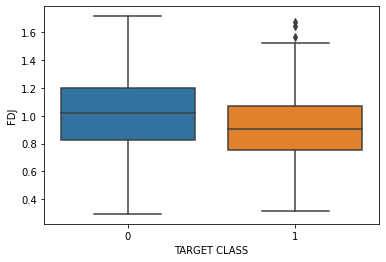

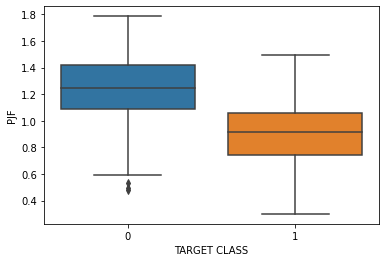

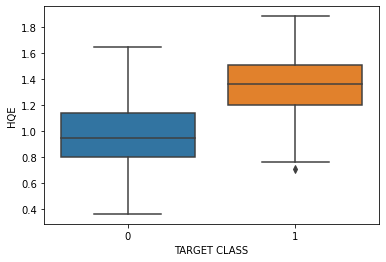

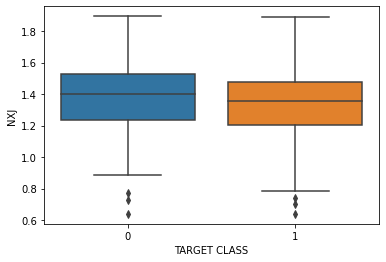

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(len(l)-1):
    sns.boxplot(x='TARGET CLASS',y=l[i], data=df)
    plt.figure()

### Scale the features using sklearn.preprocessing package

**Instantiate a scaler standardizing estimator**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

**Fit the features data only to this estimator (leaving the TARGET CLASS column) and transform**

In [ ]:
scaler.fit(df.drop('TARGET CLASS',axis=1))
scaled_features = scaler.transform(df.drop('TARGET CLASS',axis=1))

In [ ]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,-0.123542,0.185907,-0.913431,0.319629,-1.033637,-2.308375,-0.798951,-1.482368,-0.949719,-0.643314
1,-1.084836,-0.430348,-1.025313,0.625388,-0.444847,-1.152706,-1.129797,-0.202240,-1.828051,0.636759
2,-0.788702,0.339318,0.301511,0.755873,2.031693,-0.870156,2.599818,0.285707,-0.682494,-0.377850
3,0.982841,1.060193,-0.621399,0.625299,0.452820,-0.267220,1.750208,1.066491,1.241325,-1.026987
4,1.139275,-0.640392,-0.709819,-0.057175,0.822886,-0.936773,0.596782,-1.472352,1.040772,0.276510


### Train/Test split, model fit and prediction

In [ ]:
from sklearn.model_selection import train_test_split
X = df_feat
y = df['TARGET CLASS']
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['TARGET CLASS'],
                                                    test_size=0.50, random_state=101)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
pred = knn.predict(X_test)

**Evaluation of classification quality**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
conf_mat=confusion_matrix(y_test,pred)
print(conf_mat)

[[233  17]
 [ 24 226]]


In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       250
           1       0.93      0.90      0.92       250

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



In [ ]:
print("Misclassification error rate:",round(np.mean(pred!=y_test),3))

Misclassification error rate: 0.082


**Choosing 'k' by elbow method**

In [ ]:
error_rate = []

# Will take some time
for i in range(1,60):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error (misclassification) Rate')

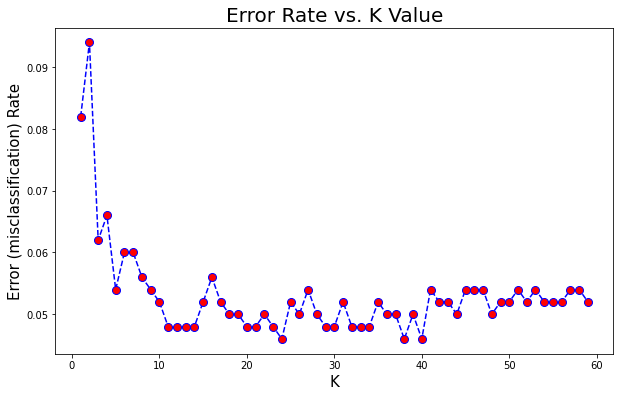

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value', fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('Error (misclassification) Rate',fontsize=15)